# PROJECT: Course Optimization for Data Science
## Optimization strategies for the proportional odds model


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the proportional odds model
- Implement your own solvers for L1 or L2 regularization with: (Accelerated) Proximal gradient descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the proportional odds model and test it on the `wine quality` dataset.

### Remarks:

- This project involves some numerical difficulty due to the presence of many `log` and `exp` functions.
- The correct and stable computation of the gradient is quite difficult. For this reason you have the possibility to use the `autograd` package to compute the gradient by automatic differentiation. `autograd` inspired the design of `pytorch`. It is a pure python package which makes it easy to install, and it is sufficient for our usecase.

## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 20th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "clement"
ln1 = "hardy"
fn2 = "felix"
ln2 = "larrouy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_hardy_clement_and_larrouy_felix.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Proportional odds model

This model is an ordinal regression model. It is a supervised learning model, in the case where the target space $Y$ is discrete: $Y=\{1, \dots, k\}$; this is the case in multiclass classification for example. Its specificity is that we assume there is an order in the output space. 

Intuitively, it means that if the true label is 2, predicting 5 is worse that predicting 3 (as 3 is closer to 2 than 5 is). For a usual classification loss, each bad prediction costs the same. In the case of the proportional odds model, **it costs more to predict values that are farther from the true target**.

The proportional odds model can be seen as an extension to the logistic regression model as we will see now.

Working with observations in $\mathbb{R}^p$, the proportional odds model has the following structure for $1 \leq j \leq k-1$:

$$
\log \left ( \frac{P(Y \leq j \mid x)}{P(Y > j \mid x)} \right ) = \alpha_j + \beta^T x ,
$$

where $\beta \in \mathbb{R}^p$ and $\alpha = \{ \alpha_j \}_{j=1}^{k-1}$ is an increasing sequence of constants ($\alpha_1 \leq \alpha_2 \leq \dots \leq \alpha_{k-1}$). We omit here the last term since $P(Y \leq k) = 1$.
Since $P(Y > j | x) = 1 - P(Y \leq j | x)$, we can rewrite the previous equation as:
$$
P(Y \leq j \mid x) = \frac{e^{\alpha_j + \beta^T x}}{e^{\alpha_j + \beta^T x} + 1} = \phi(\alpha_j + \beta^T x)
$$

and 

$$
P(Y = j \mid x) = \frac{e^{\alpha_j + \beta^T x}}{e^{\alpha_j + \beta^T x} + 1} - \frac{e^{\alpha_{j-1} + \beta^T x}}{e^{\alpha_{j-1} + \beta^T x} + 1} = \phi(\alpha_j + \beta^T x) - \phi(\alpha_{j-1} + \beta^T x)
$$

for $2 \leq j \leq k-1$, where $\phi$ denotes the sigmoid function $\phi(t) = 1 / (1 + \exp(-t))$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)), denoting $\{ y_{ij} \}_{j=1}^{k}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., exactly one of the $y_{ij}$ equals one and the rest are zero) the negative log likelihood becomes:

$$
f(\alpha, \beta) =
- \sum_{i=1}^{n} \left [ y_{i1} \log(\phi(\alpha_1 + \beta^T x_i)) 
+ \sum_{j=2}^{k-1} \Big( y_{ij} \log( 
\phi(\alpha_j + \beta^T x_i) - \phi(\alpha_{j-1} + \beta^T x_i)) \Big)
+ y_{ik} \log(1 - \phi(\alpha_{k-1} + \beta^T x_i)) \right ] .
$$

Introducing some $\ell_1$ or $\ell_2$ regularization on the parameter $\beta$ with regularization parameter $\lambda \ge 0$, the penalized likelihood estimation problem reads:
$$
    (\mathcal{P}_\alpha): \left\{
	\begin{aligned}
	\min_{\alpha, \beta} \quad f(\alpha, \beta) + \lambda \mathcal{R}(\beta) \\
    \alpha_1 \leq \dots \leq \alpha_{k-1}
	\end{aligned}
    \right.
$$
where $\mathcal{R}(\beta) = \|\beta\|_1$ or $\tfrac{1}{2} \|\beta\|^2_2$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P}_\alpha)$ is a convex problem.</li>
    </ul>
</div>

To show that the problem $\mathbb{P}_a$ is convex, we will first show the function $f$ is convex.
We can write $f$:

$$
f(\alpha, \beta) =
\sum_{i=1}^{n} \left [ -y_{i1} \log(\phi(\alpha_1 + \beta^T x_i)) 
+ \sum_{j=2}^{k-1} -\Big( y_{ij} \log( 
\phi(\alpha_j + \beta^T x_i) - \phi(\alpha_{j-1} + \beta^T x_i)) \Big)
- y_{ik} \log(1 - \phi(\alpha_{k-1} + \beta^T x_i)) \right ] .
$$
$f$ is a sum, so let's show every terms of $f$ is convex (a sum of convex functions is convex).

**First term:** $-y_{i1} \log(\phi(\alpha_1 + \beta^T x_i)) $:
\begin{align}
-\log(\phi(t))&=-\log\left(\frac{1}{1+e^{-t}}\right) \\
&=-log(1) + log\left(1+e^{-t}\right) \\
&= log\left(1+e^{-t}\right) \\
\end{align}

We can prove that $\phi(t)=log\left(1+e^{-t}\right)$ is convex. This function is twice differentiable.
\begin{align}
\phi^{'}(t) &= \frac{-e^{-t}}{1+e^{-t}} \\
\phi^{''}(t) &= \frac{e^{-t}(1+e^{-t}) + e^{-t}(-e^{-t})}{\left(1+e^{-t}\right)^2} \\
&= \frac{e^{-t} + e^{-2t} - e^{-2t}}{\left(1+e^{-t}\right)^2} \\
&= \frac{e^{-t}}{\left(1+e^{-t}\right)^2} \geq 0
\end{align}

Therefore this function is convex.
A composition of a convex function with an affine function is convex.
So as $\log(\phi(\alpha_1 + \beta^T x_i))$ is the composition of a convex function with an affine function ($\alpha_1 + \beta^T x_i$ is affine), the first term of $f$ is convex.

With the same argument, the **last term** $- y_{ik} \log(1 - \phi(\alpha_{k-1} + \beta^T x_i))$ is convex.

**Middel term**: $-\Big( y_{ij} \log(\phi(\alpha_j + \beta^T x_i) - \phi(\alpha_{j-1} + \beta^T x_i)) \Big)$

\begin{align}
-\log(\phi(\alpha_j + \beta^T x_i) - \phi(\alpha_{j-1} + \beta^T x_i)) &= - y_{ij} \log\left(\frac{1}{1+e^{-\alpha_j - \beta^T x_i}} - \frac{1}{1+e^{-\alpha_{j-1} - \beta^T x_i}}\right) \\
&=-log\left(\frac{(1+e^{-\alpha_{j-1}-\beta^T x_i})- (1+e^{-\alpha_{j}-\beta^T x_i})}{(1+e^{-\alpha_{j-1}-\beta^T x_i})(1+e^{-\alpha_{j}-\beta^T x_i})}\right) \\
&=log\left(1+e^{-\alpha_{j-1}-\beta^T x_i}\right) + log\left(1+e^{-\alpha_{j}-\beta^T x_i}\right) - log\left(e^{-\alpha_{j-1}-\beta^T x_i}- e^{-\alpha_{j}-\beta^T x_i}\right) \\
&=log\left(1+e^{-\alpha_{j-1}-\beta^T x_i}\right) + log\left(1+e^{-\alpha_{j}-\beta^T x_i}\right) - log\left(e^{-\beta^T x_i}(e^{-\alpha_{j-1}}- e^{-\alpha_{j}})\right) \\
&=log\left(1+e^{-\alpha_{j-1}-\beta^T x_i}\right) + log\left(1+e^{-\alpha_{j}-\beta^T x_i}\right) + \beta^T x_i -log\left(e^{-\alpha_{j-1}}- e^{-\alpha_{j}}\right)
\end{align}
The first three terms are convex (logistic regression, affine). The last one needs to work on it a bit more.
For simpler expression, we rewrite $\alpha_{j-1}$ as $x$ and $\alpha_j$ as $y$.
$$g(x,y) = -log\left(e^{-x}- e^{-y}\right)$$
This function is twice differentiable and so let's find the hessian of g.

The first derivative are:
$$ \frac{\partial g}{\partial x}=\frac{e^{-x}}{e^{-x}- e^{-y}}\qquad \frac{\partial g}{\partial y}=\frac{-e^{-y}}{e^{-x}- e^{-y}}$$
The second are then:
$$
\frac{\partial^2 g}{\partial^2 x}=\frac{e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2} \qquad \frac{\partial^2 g}{\partial^2 y}=\frac{e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2} \qquad \frac{\partial^2 g}{\partial x \partial y}=\frac{-e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2}
$$
So finally, the hessian is express by:
\begin{align}
\begin{pmatrix}
\frac{\partial^2 g}{\partial^2 x} & \frac{\partial^2 g}{\partial x \partial y} \\
\frac{\partial^2 g}{\partial x \partial y} & \frac{\partial^2 g}{\partial^2 y}
\end{pmatrix}&=\begin{pmatrix}
\frac{e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2} & \frac{-e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2} \\
\frac{-e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2} & \frac{e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2}
\end{pmatrix} \\
&=\frac{e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2} \begin{pmatrix}
1 & -1 \\
-1 & 1
\end{pmatrix}
\end{align}

The matrix $\begin{pmatrix} 1 & -1 \\ -1 & 1\end{pmatrix}$ has 0 and 2 for eigen value (both are positive).
As $\frac{e^{-x}e^{-y}}{\left(e^{-x}- e^{-y}\right)^2}$ is positif for all $x,y$, the hessian has two positives eigen values and so the function is convex.


Finally, every terms of the sum are convex, therefore f is convex.

The regularization is a norm which is convex, furthermore the constraints are affine, so there are also convex.

Then the problem is convex.

## Simulation

Generate data under the above model and then estimate $\alpha$ and $\beta$ using maximum likelihood

In [3]:
import numpy as np

n = 1000  # number of samples
p = 2  # number of features
k = 3  # number of classes

#### Generate parameters and compute probability distributions for each sample

In [4]:
rng = np.random.RandomState(42)
X = 15 * rng.normal(size=(n, p))
alpha = np.sort(np.linspace(-10, 10, k - 1) + rng.randn(k - 1))
beta = rng.randn(p)

We want to compute the quantity $P(Y = j \mid x_i)$ for $j= 1, \dots , k$, and $i= 1, \dots, n$.

First, let us compute an array containing the values $P(Y < j \mid x_i)$ for $j= 1, \dots , k+1$ and $i=1, \dots, n$. (we denote this array `F`):

In [5]:
def phi(t):
    return 1. / (1. + np.exp(-t))

F = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
F = np.concatenate([np.zeros((n , 1)), F, np.ones((n , 1))], axis=1)
F

array([[0.00000000e+00, 1.19425874e-07, 9.89950079e-01, 1.00000000e+00],
       [0.00000000e+00, 9.22303606e-12, 7.54978894e-03, 1.00000000e+00],
       [0.00000000e+00, 1.10105626e-03, 9.99998900e-01, 1.00000000e+00],
       ...,
       [0.00000000e+00, 2.52740373e-09, 6.75810908e-01, 1.00000000e+00],
       [0.00000000e+00, 1.85838624e-03, 9.99999349e-01, 1.00000000e+00],
       [0.00000000e+00, 4.98712917e-03, 9.99999758e-01, 1.00000000e+00]])

In [6]:
# compute P(Y = j | x)
proba = np.diff(F, axis=1)
assert proba.shape == (n, k)
proba

array([[1.19425874e-07, 9.89949960e-01, 1.00499208e-02],
       [9.22303606e-12, 7.54978894e-03, 9.92450211e-01],
       [1.10105626e-03, 9.98897844e-01, 1.09991567e-06],
       ...,
       [2.52740373e-09, 6.75810905e-01, 3.24189092e-01],
       [1.85838624e-03, 9.98140963e-01, 6.51184001e-07],
       [4.98712917e-03, 9.95012629e-01, 2.41894393e-07]])

The sum of all probas for each sample should be 1:

In [7]:
np.testing.assert_allclose(np.sum(proba, axis=1), np.ones(n))

#### Simulate $Y$ according to $P(Y = j \mid x)$

In [8]:
y = np.array([rng.choice(np.arange(k), size=1, p=pi)[0] for pi in proba])
y[:10]

array([1, 2, 1, 2, 1, 1, 1, 0, 1, 0])

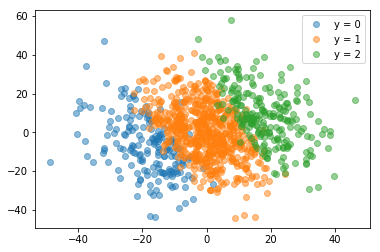

In [9]:
for j in range(k):
    Xj = X[y == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)

plt.legend();

# Log-Likelihood function

We adopt the parametrization from $(\mathcal{P}_\alpha)$. The vector of parameters `params` has `k-1 + p` entries. The first `k-1` are the alphas $\alpha$ and the last `p` entries correspond to $\beta$. The function that predicts the probabilities of each sample reads:

In [10]:
def predict_proba_alphas(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (k - 1 + p,)
        Parameters of the model. The first k - 1 entries are the alpha_j,
        the remaining p ones are the entries of beta.
        
    X: array, shape (n, p)
        Design matrix.
        
    Returns
    -------
    proba : ndarray, shape (n, k)
        The proba of belonging to each class for each sample.
    """
    n_samples, n_features = X.shape
    n_thresh = params.size - n_features
    alpha = params[:n_thresh]
    beta = params[n_thresh:]
    F = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
    F = np.concatenate(
        [np.zeros((n_samples , 1)), F, np.ones((n_samples , 1))], axis=1)
    proba = np.diff(F, axis=1)
    return proba

One-hot encoding of `y` can be done with scikit-learn `LabelBinarizer`. As it's a matrix, we call it `Y`:

In [11]:
from sklearn import preprocessing

def binarize(y):
    le = preprocessing.LabelBinarizer()
    Y = le.fit_transform(y)
    if Y.shape[1] == 1:
        Y = np.concatenate([1 - Y, Y], axis=1)
    return Y

Y = binarize(y)
Y[:10]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

The negative log-likelihood then reads:

In [12]:
def negloglik_alphas(params, X=X, Y=Y):
    proba = predict_proba_alphas(params, X)
    assert Y.shape == proba.shape
    return -np.sum(np.log(np.sum(proba * Y, axis=1) + np.finfo('float').eps))

params = np.concatenate([alpha, beta])
negloglik_alphas(params)

173.86949983576653

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>Justify why applying coordinate descent or proximal gradient descent to $(\mathcal{P}_\alpha)$ is not easy (or even possible?).</li>
    </ul>
</div>

The causes are the contraints on $\alpha$  ($\alpha_1 \leq \dots \leq \alpha_{k-1}$), thoses contraints aren't separable.
Each space of $\alpha_i$ depend on the value of the other $\alpha_j$, so each coordinate depend on the others.
With a coordinate descent, the contraints wouldn't necessary be respected (a projection on an affine space would be necessary, it seems really complicated to optimize such a problem).

## Reparametrization

To fix the problem, we propose to reparametrize the problem with a new vector $\eta \in \mathbb{R}^{k-1}$ such that $\alpha_j = \sum_{l=1}^{j} \eta_l$ with $\eta_j \geq 0$ for $j \geq 2$.

We denote by $\mathcal{L}(\eta, \beta)$ the corresponding negative log-likelihood:

$$
\mathcal{L}(\eta, \beta) =
- \sum_{i=1}^{n} \left [ y_{i1} \log \left ( \phi(\eta_1 + \beta^T x_i) \right )
+ \sum_{j=2}^{k-1} y_{ij} \log \left ( \phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i) \right ) + y_{ik} \log \left ( 1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i) \right ) \right ] .
$$


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Show that $(\mathcal{P}_\alpha)$ can be rewritten as an unconstrained convex problem $(\mathcal{P}_\eta)$.
$$
    (\mathcal{P}_\eta): \left\{
	\begin{aligned}
	\min_{\eta \in \mathbb{R}^{k-1}, \beta \in \mathbb{R}^{p}} \quad \mathcal{L}(\eta, \beta) + \lambda \mathcal{R}(\beta) + \sum_{j=2}^{k-1} g_j(\eta_j)\\
	\end{aligned}
    \right.
$$
          You will detail what are the functions $g_j$.
    </li>
    <li>
        Justify that the problem can be solved with Proximal Gradient Descent, Proximal Coordinate Descent and the L-BFGS-B algorithm (implemented in scipy.optimize).
    </li>
    </ul>
</div>

The constraints of the problem $\mathcal{P}_\alpha$ are $ \alpha_j - \alpha_{j-1} \geq 0 ,\  \forall j \in \{2, \dots, k-1\} $.
By using the new expression of $\alpha_j=\sum_{l=1}^j\eta_l$, we find 

\begin{align}
\alpha_j - \alpha_{j-1}&=\alpha_j=\sum_{l=1}^j\eta_l - \sum_{l=1}^{j-1}\eta_l \\
&=\eta_j
\end{align}
So the constraints become $\eta_j \geq 0\ \forall j \in \{2, \dots, k-1\}$.

With the new parametrization the problem become:

$$
    (\mathcal{P}_\eta): \left\{
	\begin{aligned}
	\min_{\eta \in \mathbb{R}^{k-1}, \beta \in \mathbb{R}^{p}} \quad \mathcal{L}(\eta, \beta) + \lambda \mathcal{R}(\beta)\\
    \eta_2,\eta_3,...\eta_{k-1}\ge 0
	\end{aligned}
    \right.
$$

We would like to transform such a contrained problem to an unconstrained problem, for that we will use the indicator function of $\mathcal{R^{+}}$.
So $g_j$ is the following function:
$$
g_j(\eta_j)=
\left\lbrace
\begin{matrix}
0,\quad \text{if } \eta_j\ge 0 \\
+\infty,\quad \text{otherwise}
\end{matrix}
\right.
$$

$g_j$ is a convex function, $\mathcal{L}$ and $\mathcal{R}$ are also convex, the problem is then convex.


With such a reparametrization, the problem is now unconstrainded.
$\mathcal{L}$ is convex and smooth (need to prove it), and $\mathcal{R} + \sum g_j$ is convex and prox-friendly (proximal of a norm and separable indicator functions). This problem can be then solved by proximal gradient descent and proximal coordiante descent.
The indicator functions are computationally difficult to use for L-BFGS algorithm but we can use the separable contraints ($\eta_j \geq 0$), and the problem can be then solved by L-BFGS algorithm.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Introducing the functions $f_2(\eta, \beta) = \tfrac{\lambda}{2}\|\beta\|_2^2 + \sum_{j=2}^{k-1} g_j(\eta_j)$ (corresponding to the case where $\mathcal{R}=\tfrac{1}{2}\|\beta\|_2^2$) and $f_1(\eta, \beta) = \lambda \|\beta\|_1 + \sum_{j=2}^{k-1} g_j(\eta_j)$ (corresponding to the case where $\mathcal{R}=\|\beta\|_1$), compute and implement the proximal operators of $f_1$ and $f_2$.
    </li>
    </ul>
</div>

In the code below, `lambda` being a reserved keyword in Python, we denote $\lambda$ by `reg`.

$f_1 $ and $f_2$ are two seperable function ($f(\eta,\beta)=g(\eta)+h(\beta)$).
The proximal of such a function can be written like 
$$
prox_f(\eta,\beta)=
\begin{pmatrix}
prox_g(\eta) \\
prox_h(\beta)
\end{pmatrix}
$$
In consequence, the proximal operator of $f_1$ is:
$$
prox_{f_1}(\eta,\beta)=
\begin{pmatrix}
max(0,\eta) \\
sign(\beta)max(0,|\beta|-\lambda) 
\end{pmatrix}
$$

The proximal operator of $f_2$ is:
$$
prox_{f_2}(\eta,\beta)=
\begin{pmatrix}
max(0,\eta) \\
\frac{\beta}{1+\lambda}
\end{pmatrix}
$$

(-1, 3)

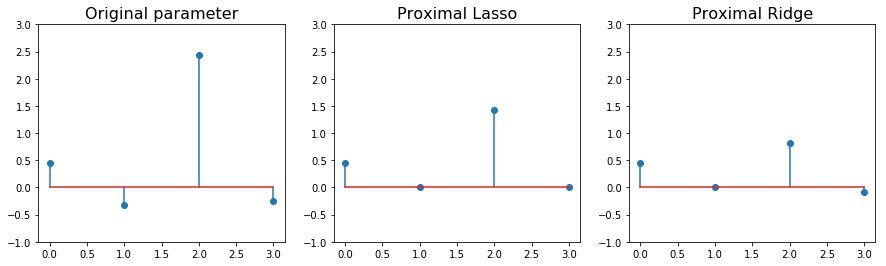

In [13]:
def prox_f2(params, reg=1., n_classes=k):
    # TODO
    # END TODO
    eta = params[1:-(k-1)]
    beta = params[(k-1):]
    params1 = params.copy()
    params1[(k-1):] = beta / (1. + reg)
    params1[1:-(k-1)] = np.maximum(0, eta)
    
    return params1


def prox_f1(params, reg=1., n_classes=k):
    # TODO
    eta = params[1:-(k-1)]
    beta = params[(k-1):]
    params1 = params.copy()
    params1[(k-1):] = np.sign(beta) * np.maximum(0, np.abs(beta) - reg)
    params1[1:-(k-1)] = np.maximum(0, eta)
    # END TODO
    return params1

rng = np.random.RandomState(5)
x = rng.randn(p + k - 1)
l_l1 = 1.
l_l2 = 2.
ylim = [-1, 3]
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 3, 2)
plt.stem(prox_f1(x, l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 3, 3)
plt.stem(prox_f2(x, l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`, without specifying the gradient function. In this case, the [`fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html) function will approximate the gradient using a finite difference method.

<div class="alert alert-success">
    <b>QUESTION 5:</b>
    <ul>
    <li>
        Implement the new predict_proba function using the new parametrization with $\eta$
    </li>
    </ul>
</div>

In [14]:
def predict_proba(params, X=X):
    """Compute the probability of every sample in X.
    
    Parameters
    ----------
    params : ndarray, shape (k - 1 + p,)
        The parameters. The first k-1 values are the etas
        and the last p ones are beta.
        
    X: array, shape (n, p)
        Design matrix.
    
    Returns
    -------
    proba : ndarray, shape (n, k)
        The proba of belonging to each class for each sample.
    """
    n_samples, n_features = X.shape
    n_thresh = params.size - n_features
    eta = params[:n_thresh]
    beta = params[n_thresh:]
    alpha = eta.cumsum()
    F = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
    F = np.concatenate(
        [np.zeros((n_samples , 1)), F, np.ones((n_samples , 1))], axis=1)
    proba = np.diff(F, axis=1)
    
    return proba


def negloglik(params, X=X, Y=Y):
    """Compute the negative log-likelihood.
    
    Parameters
    ----------
    params : ndarray, shape (p + k - 1,)
        The parameters. The first k-1 values are the etas
        and the remaining ones are the entries of beta.
    
    Returns
    -------
    nlk : float
        The negative log-likelihood to be minimized.
    """
    proba = predict_proba(params, X=X)
    assert Y.shape == proba.shape
    return -np.sum(np.log(np.sum(proba * Y, axis=1) + np.finfo('float').eps))

The next cell is to check your implementation:

In [15]:
# Check your implementation
def alpha_to_eta(alpha):
    eta = alpha.copy()
    eta[1:] = np.diff(alpha)
    return eta

# Compute with P_alpha parametrization:
negloglik_alphas(np.concatenate([alpha, beta]))

# Compute with P_eta parametrization:
eta = alpha_to_eta(alpha)
params = np.concatenate([eta, beta])

# Check that log-likelihoods match
assert abs(negloglik(params) - negloglik_alphas(np.concatenate([alpha, beta]))) < 1e-10

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function.
    </li>
    </ul>
</div>

HINT: You can specify positivity contraints for certain variables using the `bounds` parameter of `fmin_l_bfgs_b`. Infinity for numpy is `np.inf`.

The estimate of $\beta$ (resp. $\eta$ and $\alpha$) should be called `beta_hat` (resp. `eta_hat` and `alpha_hat`)

In [16]:
from scipy.optimize import fmin_l_bfgs_b

# TODO
param_init = np.zeros(p+k-1)
constraints = [(None, None)] + [(0, np.inf)] *(k-2) + [(None, None)]*p 
param_min, f_min, _ = fmin_l_bfgs_b(negloglik, param_init, args=(X,Y), pgtol=1e-30,
                                    factr=1e-30, approx_grad=True, bounds=constraints)
beta_hat = param_min[k:]
eta_hat = param_min[:k]
# END TODO

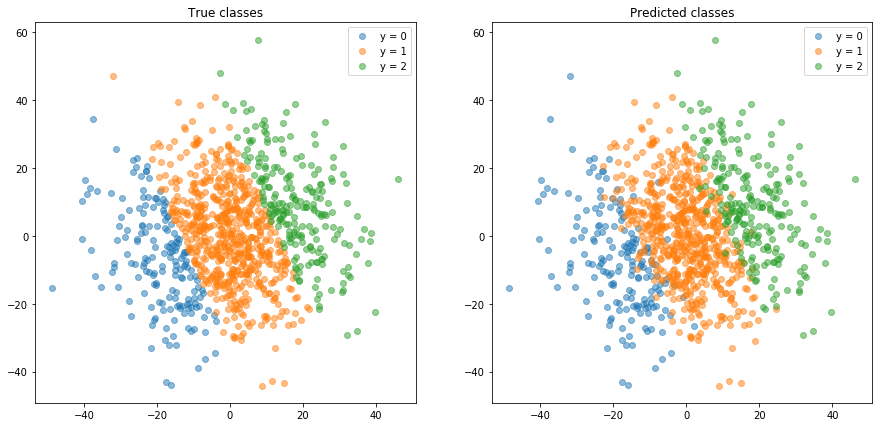

In [17]:
Y_proba = predict_proba(np.concatenate([eta_hat, beta_hat]))
y_pred = np.argmax(Y_proba, axis=1)

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
for j in range(k):
    Xj = X[y_pred == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)
plt.title("True classes")
plt.legend()

plt.subplot(1,2,2)
for j in range(k):
    Xj = X[y == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)
plt.title("Predicted classes")
plt.legend()

Visually our classifier seem to good, to confirm this we can look at the proportion of correct prediction.

In [18]:
print("The proportion of correct predictions is: {}".format(np.mean(y == y_pred)))

The proportion of correct predictions is: 0.93


### Computation of the gradients

We have so far been lazy by asking `fmin_l_bfgs_b` to approximate the gradient.
You are going to fix this using either one of the next 2 options:

<div class="alert alert-success">
    <b>QUESTION 7 (option 1):</b>
    <ul>
    <li>
        Implement the function grad_negloglik that computes the gradient of negloglik.
    </li>
</ul>
</div>

<div class="alert alert-success">
    <b>QUESTION 7 (option 2):</b>
    <ul>
    <li>
        Implement the function grad_negloglik that computes the gradient of negloglik
        using the <a href="https://github.com/HIPS/autograd">autograd</a> package.
    </li>
    </ul>
</div>

**HINT** : QUESTION 7 (option 1) you can use the fact that: $\log(\phi(t))' = 1 - \phi(t)$ and $\phi(t)' = \phi(t) (1 - \phi(t))$

You can check your implementation of the function `grad_negloglik` with the check_grad function. However **WARNING** your code is likely to be numerically quite unstable due to the numerous `log` and `exp` with tiny values that are probabilities. You may want to work with log of probabilities but **warning** this is not easy...

We have the following function
$$
\mathcal{L}(\eta, \beta) =
- \sum_{i=1}^{n} \left [ y_{i1} \log \left ( \phi(\eta_1 + \beta^T x_i) \right )
+ \sum_{j=2}^{k-1} y_{ij} \log \left ( \phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i) \right ) + y_{ik} \log \left ( 1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i) \right ) \right ] .
$$
The derivative is then:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \eta_1}&=- \sum_{i=1}^{n}\left[y_{i1} \frac{\partial \log \left ( \phi(\eta_1 + \beta^T x_i) \right)}{\partial \eta_1}
+ \sum_{j=2}^{k-1} y_{ij} \frac{\partial \log \left ( \phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i) \right )}{\partial \eta_1} + y_{ik} \frac{\partial \log \left ( 1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i) \right )}{\partial \eta_1} \right ]  \\
&=- \sum_{i=1}^{n} y_{i1} \frac{\phi^{'}(\eta_1 + \beta^T x_i)}{\phi(\eta_1 + \beta^T x_i)} + \sum_{j=2}^{k-1} y_{ij} \frac{\phi^{'}(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi^{'}(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i)}{\phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i)} - y_{ik}\frac{\phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i)}{1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i)}
\end{align}


\begin{align}
\frac{\partial \mathcal{L}}{\partial \eta_t} &=- \sum_{i=1}^{n} y_{it}\frac{\phi^{'}(\sum_{l=1}^{t} \eta_l + \beta^T x_i)}{\phi(\sum_{l=1}^{t} \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{t-1} \eta_l + \beta^T x_i)} + \sum_{j=t+1}^{k-1} y_{ij} \frac{\phi^{'}(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi^{'}(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i)}{\phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i)} - y_{ik}\frac{\phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i)}{1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i)}
\end{align}


\begin{align}
\frac{\mathcal{\partial L}(\eta, \beta)}{\partial \beta} &=
- \sum_{i=1}^{n} \left [ y_{i1} \frac{\partial \log \left ( \phi(\eta_1 + \beta^T x_i) \right )}{\partial \beta}
+ \sum_{j=2}^{k-1} y_{ij} \frac{\partial \log \left ( \phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i) \right )}{\partial \beta} + y_{ik} \frac{\partial \log \left ( 1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i) \right )}{\partial \beta} \right ]\\
&=- \sum_{i=1}^{n} y_{i1} x_i\frac{\phi^{'}(\eta_1 + \beta^T x_i)}{\phi(\eta_1 + \beta^T x_i)} + \sum_{j=2}^{k-1} y_{ij} x_i \frac{\phi^{'}(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi^{'}(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i)}{\phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i)} - y_{ik}x_i\frac{\phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i)}{1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i)}
\end{align}

In [19]:
# Option 1
from scipy.misc import logsumexp

def grad_negloglik(params, X=X, Y=Y):
    
    n_samples, n_features = X.shape
    n_thresh = params.size - n_features
    eta = params[:n_thresh]
    beta = params[n_thresh:]
    alpha = eta.cumsum()
    PHI = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
    PHI_prime = PHI * (1-PHI)
    
    PHI = np.concatenate(
        [np.zeros((n_samples , 1)), PHI, np.ones((n_samples , 1))], axis=1)
    
    PHI_prime = np.concatenate(
        [np.zeros((n_samples , 1)), PHI_prime, np.zeros((n_samples , 1))], axis=1)
    
    L_prime = np.zeros(params.size)
    
    j = 0
    proba = np.diff(PHI, axis=1)
    proba_prime = np.diff(PHI_prime, axis=1) 
    F = proba_prime/(proba + np.finfo('float').eps)
    
    for i in range(n_thresh, params.size):
        L_prime[i] = -np.nansum(np.nansum((F * Y).T * X[:,j] , axis=0))
        j += 1
        
    
    for i in range(n_thresh):
        PHI_prime[:,i] = 0
        proba = np.diff(PHI, axis=1)
        proba_prime = np.diff(PHI_prime, axis=1) 
        F = proba_prime/(proba + np.finfo('float').eps)
        L_prime[i] = -np.nansum(np.nansum(F * Y, axis=1))
        
    return L_prime  

To avoid the loop over the $\eta$ , we can use the fact that $\alpha_j = \sum_{l=1}^{j} \eta_l$, compute the gradient of alpha and then use the following fact:

$$
\frac{\partial \mathcal{L}}{\partial \eta_i}= \sum_{j=i}^{k-1}\frac{\partial \mathcal{L}}{\partial \alpha_j}
$$

In [20]:
def grad_alpha(params, X=X, Y=Y):
    
    n_samples, n_features = X.shape
    n_thresh = params.size - n_features
    eta = params[:n_thresh]
    beta = params[n_thresh:]
    alpha = eta.cumsum()
    
    PHI = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
    PHI_prime = PHI*(1-PHI)
    
    PHI = np.concatenate(
        [np.zeros((n_samples , 1)), PHI, np.ones((n_samples , 1))], axis=1)
    
    proba = np.diff(PHI, axis=1)
    
    p1 = Y[:,:-1] * PHI_prime/(proba[:,:-1] + np.finfo('float').eps)
    p2 = -Y[:,1:] * PHI_prime/(proba[:,1:] + np.finfo('float').eps)
    
    L_prime = np.zeros(params.size)
    grad_alpha = -np.nansum(p1 + p2, axis=0)
    L_prime[:n_thresh] = (np.cumsum(grad_alpha[::-1]))[::-1]
    
    PHI_prime = np.concatenate(
        [np.zeros((n_samples , 1)), PHI_prime, np.zeros((n_samples , 1))], axis=1)
    proba_prime = np.diff(PHI_prime, axis=1) 
    F = proba_prime/proba
    
    j = 0
    for i in range(n_thresh, params.size):
        L_prime[i] = -np.nansum(np.nansum((F * Y).T * X[:,j] , axis=0))
        j += 1
        
    
    return L_prime

In [21]:
# Option 2

import autograd.numpy as np
from autograd import grad

def negloglik_autograd(params, X=X, Y=Y):
    """Compute the negative log-likelihood

    Parameters
    ----------
    params : ndarray, shape (p + k - 1,)
        The parameters. The first k-1 values are the etas
        and the remaining p ones correspond to beta.
    X : ndarray, shape (n, p)
        Design matrix.
    Y : ndarray, shape (n, k)
        The target after one-hot encoding.

    Returns
    -------
    nlk : float
        The negative log-likelihood to be minimized.
    """
    # TODO
    return negloglik(params=params, X=X, Y=Y)
    # END TODO

grad_negloglik_auto = grad(negloglik_autograd)

In [22]:
from scipy.optimize import check_grad
rng = np.random.RandomState(42)
x0 = rng.randn(p + k - 1)
x0[1:k - 1] = np.abs(x0[1:k - 1])
#x0 = np.ones(x0.shape) *0
# WARNING: check_grad is likely to return a quite high value
# due to numerical instability with exp and log with tiny
# probability values. Don't be surprised as long as your
# solvers below converge.
print('At the point: {}\n'.format(x0))
print("\t check autograd: {}".format(check_grad(negloglik, grad_negloglik_auto, x0=x0)))
print("\t check grad manuel: {}".format(check_grad(negloglik, grad_negloglik, x0=x0)))
print("\t check grad manuel via alpha: {}".format(check_grad(negloglik, grad_alpha, x0=x0)))
print("\t autograd: {}".format(grad_negloglik_auto(x0)))
print("\t grad manuel: {}".format(grad_negloglik(x0, X, Y)))
print("\t grad manuel via alpha: {}".format(grad_alpha(x0, X, Y)))



rng = np.random.RandomState(43)
x0 = rng.randn(p + k - 1)
x0[1:k - 1] = np.abs(x0[1:k - 1])
#x0 = np.ones(x0.shape) *0
# WARNING: check_grad is likely to return a quite high value
# due to numerical instability with exp and log with tiny
# probability values. Don't be surprised as long as your
# solvers below converge.
print('\n\nAt the point: {}\n'.format(x0))
print("\t check autograd: {}".format(check_grad(negloglik, grad_negloglik_auto, x0=x0)))
print("\t check grad manuel: {}".format(check_grad(negloglik, grad_negloglik, x0=x0)))
print("\t check grad manuel via alpha: {}".format(check_grad(negloglik, grad_alpha, x0=x0)))
print("\t autograd: {}".format(grad_negloglik_auto(x0)))
print("\t grad manuel: {}".format(grad_negloglik(x0, X, Y)))
print("\t grad manuel via alpha: {}".format(grad_alpha(x0, X, Y)))



At the point: [0.49671415 0.1382643  0.64768854 1.52302986]

	 check autograd: 10567.839087578113
	 check grad manuel: 10607.312645947202
	 check grad manuel via alpha: 8801.987785438807
	 autograd: [   29.945785   -3842.79818107  3756.1520214   6173.4791328 ]
	 grad manuel: [   27.58394999 -3843.410883    3723.67050005  6130.40952072]
	 grad manuel via alpha: [   27.58394999 -3843.410883    4518.12591962  8082.56754748]


At the point: [ 0.25739993  0.90848143 -0.37850311 -0.5349156 ]

	 check autograd: 14.43535754321454
	 check grad manuel: 14.435357076985907
	 check grad manuel via alpha: 14.43536342319892
	 autograd: [   65.93515261  -640.01956027   534.99832492 -6116.04071383]
	 grad manuel: [   65.93515258  -640.01956025   534.99832479 -6116.04071262]
	 grad manuel via alpha: [   65.93515258  -640.01956025   534.99832865 -6116.0407325 ]


C:\Users\Clement_X240\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:166: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.concatenate((-g[sl1], -anp.diff(g, axis=axis), g[sl2]), axis=axis)
C:\Users\Clement_X240\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: invalid value encountered in true_divide


The gradient is numerically unstable (the point where the gradient is calculated influence a lot the result), but our implementation seem correct as our result is nearly equal to autograd result in both cases (a case where the gradient is unstable and the other where the gradient seem to be more stable even if it's still a little unstable).

Now plug your gradient into L-BFGS and check the result:

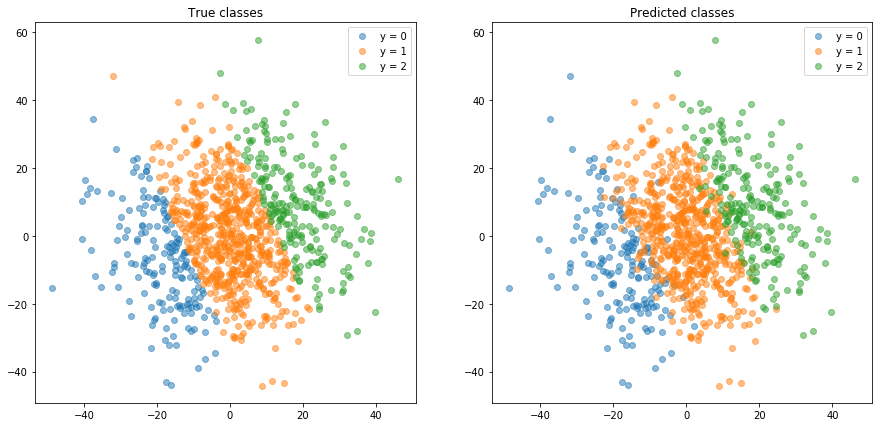

In [23]:
x0 = np.zeros(p + k - 1)
x0[:k - 1] = np.arange(k - 1)  # initiatlizing with etas all equal to zero is a bad idea!
bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
x_hat, _, _ = fmin_l_bfgs_b(negloglik, fprime=grad_negloglik,
                            x0=x0, bounds=bounds)
Y_proba = predict_proba(x_hat)
y_pred = np.argmax(Y_proba, axis=1)

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
for j in range(k):
    Xj = X[y_pred == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)
plt.title("True classes")
plt.legend()

plt.subplot(1,2,2)
for j in range(k):
    Xj = X[y == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)
plt.title("Predicted classes")
plt.legend()

In [24]:
print("The proportion of correct prediction is: {}".format(np.mean(y==y_pred)))

The proportion of correct prediction is: 0.93


The gradient computation seem correct as the proportion of correct prediction is high (the L-BGFS use the gradient).

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, y and lbda that implements
        the function proportional_odds_lbfgs_l2 that will be
        used to get a good value of x_min (minimum of the L2 regularized
        model).
    </li>
    </ul>
</div>

To help you we give you the code of the objective to minimize
in case you use $\ell_1$ or $\ell_2$ penalty.

In [25]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    n_features = X.shape[1]
    beta = params[-n_features:]
    n_thresh = Y.shape[1] - 1
    eta = params[:n_thresh]
    if np.any(eta[1:] < 0):
        return np.inf
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(beta))


def pobj_l2(params, X=X, Y=Y, lbda=1.):
    n_features = X.shape[1]
    beta = params[-n_features:]
    n_thresh = Y.shape[1] - 1
    eta = params[:n_thresh]
    if np.any(eta[1:] < 0):
        return np.inf
    return negloglik(params, X=X, Y=Y) + lbda / 0.5 * np.dot(beta, beta)

In [26]:
def proportional_odds_lbfgs_l2(X, y, lbda):
    Y = binarize(y)
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]

    # TODO
    x0 = np.zeros(p + k - 1)
    x0[:k - 1] = np.arange(k - 1)
    bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
    x_min, _, _ = fmin_l_bfgs_b(pobj_l2, fprime=grad_negloglik,
                            x0=x0, bounds=bounds)
    # END TODO
    return x_min

x_min = proportional_odds_lbfgs_l2(X, y, lbda=1.)

Check that `x_min` is ok.

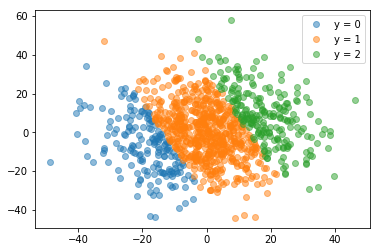

In [27]:
Y_proba = predict_proba(x_min)
y_pred = np.argmax(Y_proba, axis=1)

for j in range(k):
    Xj = X[y_pred == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)

plt.legend();

In [28]:
print("The proportion of correct prediction is: {}".format(np.mean(y==y_pred)))

The proportion of correct prediction is: 0.93


In [29]:
def proportional_odds_lbfgs_l1(X, y, lbda):
    Y = binarize(y)
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]

    # TODO
    x0 = np.zeros(p + k - 1)
    x0[:k - 1] = np.arange(k - 1)
    bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
    x_min, _, _ = fmin_l_bfgs_b(pobj_l1, fprime=grad_negloglik,
                            x0=x0, bounds=bounds)
    # END TODO
    return x_min

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [30]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 8a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [31]:
def pgd(x_init, grad, prox, n_iter=100, step=1., store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step * grad(x, X=grad_args[0], Y=grad_args[1]), step, lbda=prox_args[0], n_classes=prox_args[1])
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 8b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

NOTE: You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

To help you we give you the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [32]:
def prox_l1(params, step, lbda, n_classes):
    return prox_f1(params, reg=step * lbda, n_classes=n_classes)

def prox_l2(params, step, lbda, n_classes):
    return prox_f2(params, reg=step * lbda, n_classes=n_classes)

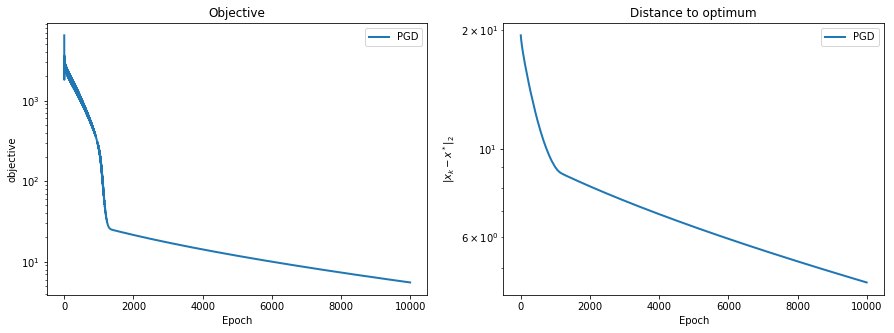

In [33]:
x_init = np.ones(p + k - 1)
x_init[:k - 1] = np.arange(k - 1)
n_iter = 10000
lbda = .1
step = 1e-4
x_min_l2 = proportional_odds_lbfgs_l2(X, y, lbda=1.)

monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min=x_min_l2, args=(X, Y, lbda))
monitor_pgd_l2.run(x_init, grad_negloglik, prox_l2, n_iter, step,
                   grad_args=(X, Y), prox_args=(lbda, k))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

The converge is very long, it's may be cause by the linear convergence of proximal gradient descent + the unstable computation of the gradient (that may increase the time to converge). Even after 10000 iterations the convergence isn't finish as we can see below.

In [34]:
print(monitor_pgd_l2.x_list[-1])
print(x_min)

[-7.1283659  13.95696182 -0.52813662 -0.21384159]
[-9.23175892 18.05436518 -0.68037421 -0.27651891]


The same aspect could be see with the $\ell_1$ regularization

Now for the $\ell_1$ regularization:

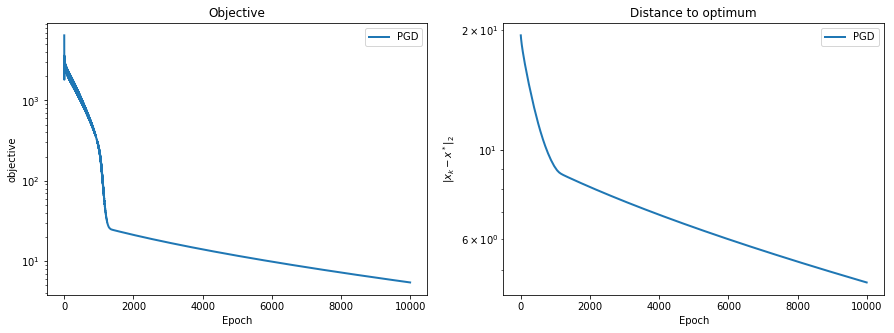

In [35]:
lbda = 1.
x_min_l1 = proportional_odds_lbfgs_l1(X, y, lbda=1.)
# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, Y, lbda))
monitor_pgd_l1.run(x_init, grad_negloglik, prox_l1, n_iter, step,
                   grad_args=(X, Y), prox_args=(lbda, k))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [36]:
def apgd(x_init, grad, prox, n_iter=100, step=1., store_every=1,
        grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step * grad(y, X=grad_args[0], Y=grad_args[1]), step, lbda=prox_args[0], n_classes=prox_args[1])
        t_new = (1. + np.sqrt(1. + 4 * t ** 2)) / 2.
        y = x_new + (t - 1.) / t_new * (x_new - x)
        x = x_new
        t = t_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

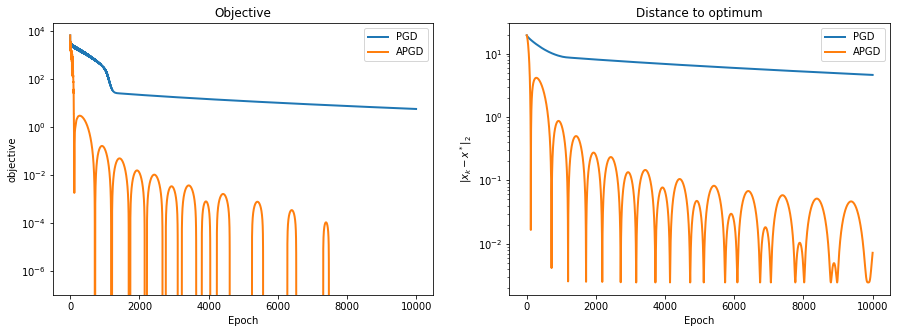

In [37]:
lbda = .1

monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min=x_min_l2, args=(X, Y, lbda))
monitor_apgd_l2.run(x_init, grad_negloglik, prox_l2, n_iter, step,
                   grad_args=(X, Y), prox_args=(lbda, k))

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

The convergence of APGD is faster as expected, APGD has a quadratic convergence rate. We can notice those big 
"waves" that may be caused by the momentum of the gradient descent (it goes to far).

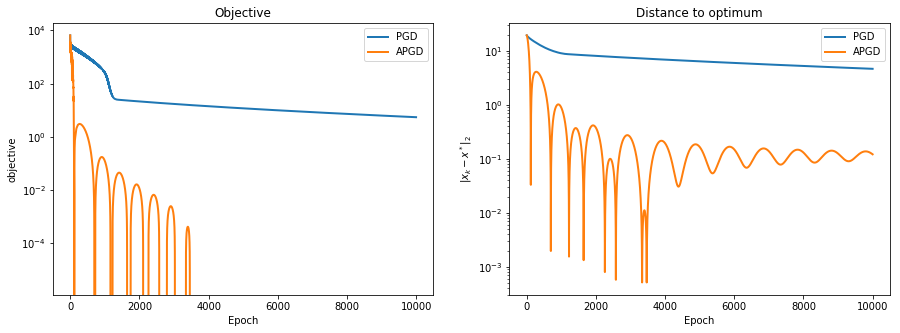

In [38]:
lbda = 1.

# TODO
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, Y, lbda))
monitor_apgd_l1.run(x_init, grad_negloglik, prox_l1, n_iter, step,
                   grad_args=(X, Y), prox_args=(lbda, k))

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `wine quality` dataset. Given 11 features
that describe certain wines (our samples), the objective it to predict the quality of the wine,
encoded by integers between 3 and 8. Rather than using a multiclass classification
model we're going to use a proportional odds model.

Let's first inspect the dataset:

In [39]:
import pandas as pd

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [40]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Now let's extract `X` and `y`

In [41]:
data = df.values
X = data[:, :-1]
y = data[:, -1] - 3
X.shape, y.shape, np.unique(y)

((1599, 11), (1599,), array([0., 1., 2., 3., 4., 5.]))

Let's do a basic scaling of the features:

In [42]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [43]:
from sklearn.base import BaseEstimator, ClassifierMixin
from autograd import grad

class ProportionalOdds(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the proportional odds model
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.
        
    Attributes
    ----------
    alpha_ : ndarray, (n_classes - 1,)
        The alphas.
    beta_ : ndarray, (n_features,)
        The regression coefficients.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'lbfgs'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """
        n_classes = int(np.max(y)) + 1
        assert np.all(np.unique(y) == np.arange(n_classes))
        Y = binarize(y)
        n_samples, n_features = X.shape
        # TODO
        
        x_init = np.zeros(n_features + n_classes - 1)
        x_init[:n_classes - 1] = np.arange(n_classes - 1)
     
        if self.solver == 'lbfgs':
            if self.penalty == 'l1':
                penal = pobj_l1
            else:
                penal = pobj_l2
                
            bounds = [(None, None)] + [(0, np.inf) for j in range(n_classes-2)] + [(None, None)] * n_features
            x, _, _ = fmin_l_bfgs_b(penal, x_init, args=(X,Y, self.lbda), pgtol=1e-30,
                                    factr=1e-30, approx_grad=True, bounds=bounds, maxiter=self.max_iter)

        else:
            if self.penalty == 'l1':
                penal = prox_l1
                
            else:
                penal = prox_l2
                
            
            step = 1e-4
            if self.solver == 'apgd':
                x, _ = apgd(x_init=x_init, grad=grad_negloglik, prox=penal, n_iter=self.max_iter, step=step,
                                grad_args=(X, Y), prox_args=(self.lbda, n_classes))
            else:
                x, _ = pgd(x_init=x_init, grad=grad_negloglik, prox=penal, n_iter=self.max_iter, step=step,
                               grad_args=(X, Y), prox_args=(self.lbda, n_classes))
        eta = x[1:-(n_classes-1)]
        beta = x[(n_classes-1):]
        # END TODO
        self.params_ = x
        self.alpha_ = eta.cumsum()
        self.beta_ = beta
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """

        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """

        return predict_proba(self.params_, X)


for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = ProportionalOdds(lbda=1., penalty='l2', max_iter=2000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y)))

for solver in ['pgd', 'apgd']:
    clf = ProportionalOdds(lbda=1., penalty='l1', max_iter=2000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y)))

Solver with L2: pgd   -   Score : 0.5959974984365228
Solver with L2: apgd   -   Score : 0.5959974984365228
Solver with L2: lbfgs   -   Score : 0.592245153220763
Solver with L1: pgd   -   Score : 0.5959974984365228
Solver with L1: apgd   -   Score : 0.5959974984365228


The three converge toward the same solution which good. We can also notice that a lambda equal to 1 doesn't seem to change a lot the result as the solvers converge towards the same solution in both case.
To see any differents we have to increase the lambda as below:

In [44]:
for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = ProportionalOdds(lbda=300., penalty='l2', max_iter=2000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y)))

for solver in ['pgd', 'apgd']:
    clf = ProportionalOdds(lbda=300., penalty='l1', max_iter=2000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y)))

Solver with L2: pgd   -   Score : 0.5766103814884302
Solver with L2: apgd   -   Score : 0.5766103814884302
Solver with L2: lbfgs   -   Score : 0.5634771732332708
Solver with L1: pgd   -   Score : 0.5259537210756723
Solver with L1: apgd   -   Score : 0.5259537210756723


<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Compare the cross-validation performance of your model with a multinomial
        logistic regression model that ignores the order between the classes. You will comment your results.
    </li>
    </ul>
</div>

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Let's use the L-BFGS solver to have a faster convergence
model = ProportionalOdds(solver='lbfgs', max_iter=1000)
scores_model = cross_val_score(model, X, y, cv=5)

multinomiale = LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs', max_iter=1000)
scores_multinomiale = cross_val_score(multinomiale, X, y, cv=5)
# END TOD

In [46]:
print("ProportionalOdds model: {}".format(np.round(scores_model.mean(), 3)))
print("Multinomial logistic regression model: {}".format(np.round(scores_multinomiale.mean(), 3)))

ProportionalOdds model: 0.586
Multinomial logistic regression model: 0.581


The score of the ProportionalOdds model is slightly better, but from this results, we could think that ProportionalOdds doesn't make a big difference with a classic multinomial classifier. Actually, results are not representative because the metric used to measure the performance of the multinomial model is the mean accuracy on the given test data and labels. If the label is 3, and the model predicts 8 or 4, it will be penalized the same way, which is not our goal in Proportional Odds.